# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

Sparkify is a popular digital musical services where users can listen to their favourite songs either using the free tier or purchase premium subscription model in which they stream music as free but pay a monthly flat rate. Understanding the behaviour and preference of users helping us in business planning. The activities carried out by the users such as logging in and out, downgrade, upgrade or services cancellation are recorded as data which can be used to predict the risk to churn for users.


Exploratory Analysis

- The relationship between gender and level of users - (paid or free) against churned users are explored. 


Feature Engineering

- Positive and negative feedbacks, interaction between users, and trends of song and artists are investigated to identify the     tendency of churn rate. The target and feature variables are defined and prepared for the use in modeling.


Modeling

- Predicting churn is a classification in machine learning. 3 classification models - Logistic Regression, Random Forest and     Gradient Boosting Tree are chosen to compare the model performance and validate the suitable hyperparameters.
  For evaluation metrics, accuracy and F1 score are evaluated. Accuracy measures how well the model in predicting churn and F1   score measures the accuracy of the model's performance.


Spark SQL, Spark DataFrame and Spark ML will be used in this analysis.

In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import count, col, concat, avg, asc, desc, min, max, split, explode, lit, udf, stddev, isnull, isnan, when
from pyspark.ml.feature import RegexTokenizer, VectorAssembler, CountVectorizer, IDF, StringIndexer, Normalizer, PCA, MinMaxScaler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier

In [2]:
# create a Spark session
spark = SparkSession\
        .builder\
        .appName("Sparkify Project")\
        .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
df = spark.read.json("mini_sparkify_event_data.json")
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [4]:
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [5]:
# Dimension of data
df.count(), len(df.columns)

(286500, 18)

This dataset has 286500 rows and 18 columns. 

In [6]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
# Statistic
df.toPandas().describe()

,itemInSession,length,registration,sessionId,status,ts
count,286500.000000,228108.000000,2.781540e+05,286500.000000,286500.000000,2.865000e+05
mean,114.414213,249.117182,1.535359e+12,1041.526555,210.054597,1.540957e+12
std,129.767262,99.235179,3.291322e+09,726.776263,31.505078,1.507544e+09
min,0.000000,0.783220,1.521381e+12,1.000000,200.000000,1.538352e+12
25%,27.000000,199.888530,1.533522e+12,336.000000,200.000000,1.539697e+12
50%,70.000000,234.500770,1.536664e+12,1013.000000,200.000000,1.540932e+12
75%,156.250000,277.158730,1.537672e+12,1675.000000,200.000000,1.542266e+12
max,1321.000000,3024.665670,1.543247e+12,2474.000000,404.000000,1.543799e+12


In [8]:
# Skewness
df.toPandas().skew(axis=0, skipna=True)

itemInSession    2.480746
length           5.338281
registration    -1.586332
sessionId        0.217484
status           2.868533
ts               0.062416
dtype: float64

In [9]:
# Kurtosis
df.toPandas().kurt(axis=0, skipna=True)

itemInSession     9.961081
length           85.489538
registration      3.205200
sessionId        -1.309083
status            6.573906
ts               -1.172516
dtype: float64

In [10]:
df.describe("userId").show()

+-------+-----------------+
|summary|           userId|
+-------+-----------------+
|  count|           286500|
|   mean|59682.02278593872|
| stddev|109091.9499991047|
|    min|                 |
|    max|               99|
+-------+-----------------+



In [11]:
# Missing values for userId
df.filter((df["userId"] == "") | df["userId"].isNull() | isnan(df["userId"])).count()

8346

In [12]:
# Filter NaN row
df = df.filter(df.userId != "")

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

Define Churn Users:

In [13]:
# Change to pandas DataFrame
df_pandas = df.toPandas()

In [14]:
df_pandas["page"].unique()

array(['NextSong', 'Add to Playlist', 'Roll Advert', 'Thumbs Up',
       'Downgrade', 'Thumbs Down', 'Home', 'Logout', 'Help', 'Upgrade',
       'Add Friend', 'Settings', 'Submit Upgrade', 'About',
       'Submit Downgrade', 'Error', 'Save Settings', 'Cancel',
       'Cancellation Confirmation'], dtype=object)

In [15]:
# List of churned users
churned_users = list(df_pandas[(df_pandas["page"] == "Cancellation Confirmation") | (df_pandas["page"] == "Submit Downgrade")]["userId"].unique())

In [16]:
# List of users
users = list(df_pandas["userId"].unique())

Compare the behavior of churn in gender:

In [17]:
# Create a dictionary of user and gender
from collections import defaultdict
user_gender = defaultdict(str)

for user in users:
    user_gender[user] = df_pandas.loc[df_pandas["userId"]==user]["gender"].values[0]

In [18]:
user_gender_df = pd.DataFrame({"UserId": list(user_gender.keys()), "Gender": list(user_gender.values())})

In [19]:
user_gender_df["Churn"] = user_gender_df["UserId"].apply(lambda x: 1 if x in churned_users else 0)

In [20]:
user_gender_df.head()

,UserId,Gender,Churn
0,30,M,1
1,9,M,1
2,74,F,1
3,54,F,1
4,4,M,0


[Text(0.5,1,'Graph of Number of Churn Users VS Gender')]

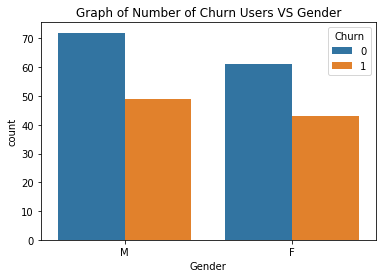

In [21]:
sns.countplot(data=user_gender_df, x="Gender", hue="Churn").set(title="Graph of Number of Churn Users VS Gender")

From the graph above, the number of churn in the male group is slightly higher than in the female group.

Compare two levels - free and paid:

In [22]:
user_level = defaultdict(str)

for user in users:
    user_level[user] = df_pandas.loc[df_pandas["userId"]==user]["level"].values[0]

In [23]:
user_level_df = pd.DataFrame({"UserId": list(user_level.keys()), "Level": list(user_level.values())})

In [24]:
user_level_df["Churn"] = user_level_df["UserId"].apply(lambda x: 1 if x in churned_users else 0)

In [25]:
user_level_df.head()

,UserId,Level,Churn
0,30,paid,1
1,9,free,1
2,74,free,1
3,54,paid,1
4,4,free,0


[Text(0.5,1,'Graph of Number of Churn Users VS Level')]

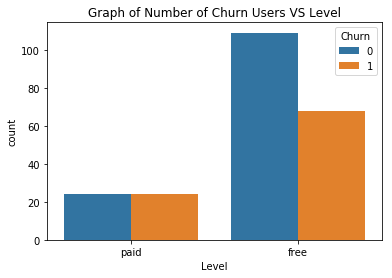

In [26]:
sns.countplot(data=user_level_df, x="Level", hue="Churn").set(title="Graph of Number of Churn Users VS Level")

Graph above shown that the level of free group has higher number of churn than paid group.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

Target Variable: 
Churn users

Feature Variable:
Average number of songs per session, thumbs up event, thumbs down event, errors event, add to playlist event, add friend event, total of songs played

In [27]:
df.createOrReplaceTempView("Table")

Create sql table and visualize average number of songs per session:

In [28]:
# Create SQL table for average number of songs per session
number_of_sessions = spark.sql("SELECT userId, AVG(c) as average\
                                FROM (SELECT userId, COUNT(*) AS c\
                                       FROM Table\
                                      GROUP BY sessionId, userId)\
                                GROUP BY userId")

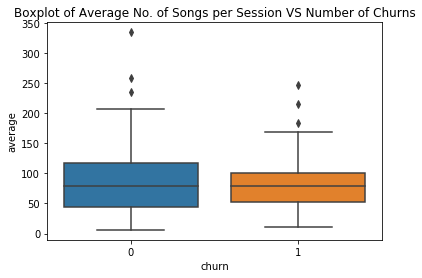

In [29]:
# Visualize the number of churn vs average number of songs per session
pd_num_sessions = number_of_sessions.toPandas()
pd_num_sessions['churn'] = pd_num_sessions['userId'].apply(lambda x: 1 if x in churned_users else 0)
sns.boxplot(x="churn", y="average", data=pd_num_sessions).set(title="Boxplot of Average No. of Songs per Session VS Number of Churns");

Create sql table and visualize thumbs up event:

In [30]:
# Create SQL table for thumbs up event
thumbs_up = spark.sql("SELECT userId, COUNT(*) AS count_thumbs_up\
                       FROM Table\
                       WHERE page = 'Thumbs Up'\
                       GROUP BY userId")

[Text(0.5,1,'Boxplot of Thumbs up VS Number of Churns')]

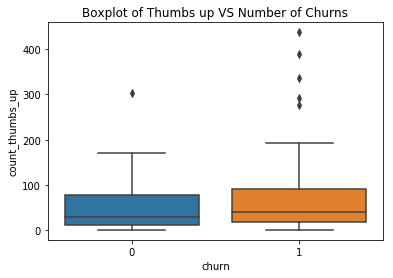

In [31]:
# Visualize the number of churn vs thumbs up event 
pd_thumbs_up = thumbs_up.toPandas()
pd_thumbs_up['churn'] = pd_thumbs_up['userId'].apply(lambda x: 1 if x in churned_users else 0)
sns.boxplot(x="churn", y="count_thumbs_up", data=pd_thumbs_up).set(title="Boxplot of Thumbs up VS Number of Churns")

Create sql table and visualize thumbs down event:

In [32]:
# Create SQL table for thumbs down event
thumbs_down = spark.sql("SELECT userId, COUNT(*) AS count_thumbs_down\
                         FROM Table\
                         WHERE page = 'Thumbs Down'\
                         GROUP BY userId")

[Text(0.5,1,'Boxplot of Thumbs Down VS Number of Churns')]

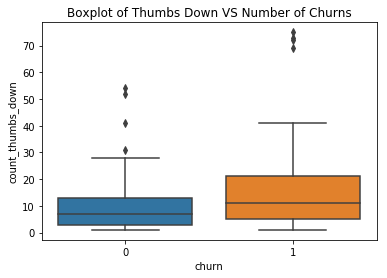

In [33]:
# Visualize the number of churn vs thumbs down event 
pd_thumbs_down = thumbs_down.toPandas()
pd_thumbs_down['churn'] = pd_thumbs_down['userId'].apply(lambda x: 1 if x in churned_users else 0)
sns.boxplot(x="churn", y="count_thumbs_down", data=pd_thumbs_down).set(title="Boxplot of Thumbs Down VS Number of Churns")

Create sql table and visualize errors event:

In [34]:
# Create SQL table for error event
errors = spark.sql("SELECT userId, count(*) AS count_errors\
                    FROM Table\
                    WHERE page = 'Error'\
                    GROUP BY userId")

[Text(0.5,1,'Boxplot of Errors VS Number of Churns')]

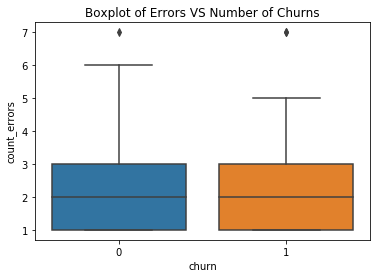

In [35]:
# Visualize the number of churn vs errors event
pd_errors = errors.toPandas()
pd_errors['churn'] = pd_errors['userId'].apply(lambda x: 1 if x in churned_users else 0)
sns.boxplot(x="churn", y="count_errors", data=pd_errors).set(title="Boxplot of Errors VS Number of Churns")

Create sql table and visualize add to playlist event:

In [36]:
# Create SQL table for add to playlist event
add_to_playlist = spark.sql("SELECT userId, count(*) as count_add_to_playlist\
                             FROM Table\
                             WHERE page = 'Add to Playlist'\
                             GROUP BY userId")

[Text(0.5,1,'Boxplot of Add to Playlist VS Number of Churns')]

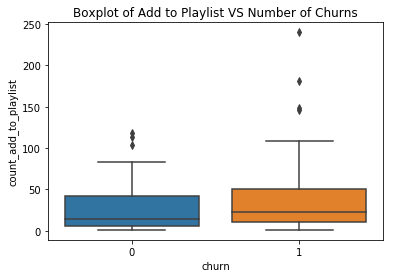

In [37]:
# Visualize the number of churn vs add to playlist event
pd_add_to_playlist = add_to_playlist.toPandas()
pd_add_to_playlist['churn'] = pd_add_to_playlist['userId'].apply(lambda x: 1 if x in churned_users else 0)
sns.boxplot(x="churn", y="count_add_to_playlist", data=pd_add_to_playlist).set(title="Boxplot of Add to Playlist VS Number of Churns")

Create sql table and visualize add friend event:

In [38]:
# Create SQL table for add friend event
add_to_friends = spark.sql("SELECT userId, count(*) as count_add_friends\
                            FROM Table\
                            WHERE page = 'Add Friend'\
                            GROUP BY userId")

[Text(0.5,1,'Boxplot of Add Friends VS Number of Churns')]

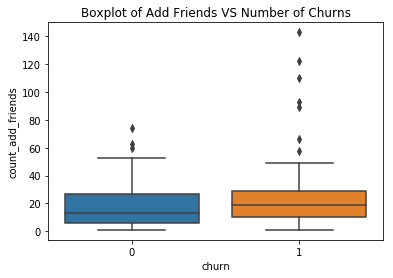

In [39]:
# Visualize the number of churn vs add friend event
pd_add_to_friends = add_to_friends.toPandas()
pd_add_to_friends['churn'] = pd_add_to_friends['userId'].apply(lambda x: 1 if x in churned_users else 0)
sns.boxplot(x="churn", y="count_add_friends", data=pd_add_to_friends).set(title="Boxplot of Add Friends VS Number of Churns")

Create sql table and visualize total of songs played:

In [40]:
# Create SQL table for total of song played
total_songs = spark.sql("SELECT userId, count(*) as count_total_songs\
                         FROM Table\
                         GROUP BY userId")

[Text(0.5,1,'Boxplot of Total Songs VS Number of Churns')]

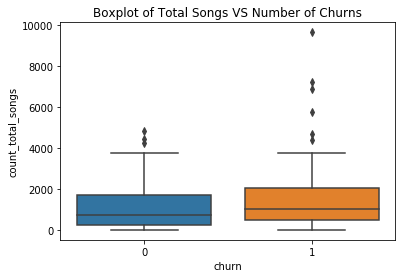

In [41]:
# Visualize the number of churn vs total of songs played
pd_total_songs = total_songs.toPandas()
pd_total_songs['churn'] = pd_total_songs['userId'].apply(lambda x: 1 if x in churned_users else 0)
sns.boxplot(x="churn", y="count_total_songs", data=pd_total_songs).set(title="Boxplot of Total Songs VS Number of Churns")

# Prepare Data for Modeling

In [42]:
# Create SQL table for churned users
a = spark.sql("SELECT userId, CASE WHEN page = 'Submit Downgrade' OR page = 'Cancellation Confirmation' THEN 1 END AS churn\
              FROM Table")
a.createOrReplaceTempView('churn_table')
b = spark.sql("SELECT * FROM churn_table WHERE churn IS NOT NULL")
b.createOrReplaceTempView('churn_users')

In [43]:
spark.sql("select * from churn_users").show(5)

+------+-----+
|userId|churn|
+------+-----+
|   131|    1|
|    38|    1|
|   141|    1|
|    18|    1|
|    30|    1|
+------+-----+
only showing top 5 rows



In [44]:
# Join all variables into one SQL table
temp1 = thumbs_down.join(thumbs_up, thumbs_down.userId == thumbs_up.userId).drop(thumbs_up.userId)
temp2 = temp1.join(errors, errors.userId == temp1.userId).drop(errors.userId)
temp3 = temp2.join(add_to_playlist, add_to_playlist.userId == temp2.userId).drop(add_to_playlist.userId)
temp4 = temp3.join(add_to_friends, add_to_friends.userId == temp3.userId).drop(add_to_friends.userId)
temp5 = temp4.join(total_songs, total_songs.userId == temp4.userId).drop(total_songs.userId)
temp6 = temp5.join(number_of_sessions, number_of_sessions.userId == temp5.userId).drop(number_of_sessions.userId)
temp7 = temp6.join(b, b.userId == temp6.userId, "left_outer").drop(b.userId)

In [45]:
# Create a temporary table and form a dataset for modeling
temp7.createOrReplaceTempView('temp_table')
train_test_df = spark.sql("SELECT userId, count_thumbs_down, count_thumbs_up, count_errors, count_add_to_playlist,\
                          count_add_friends, count_total_songs, average, CASE WHEN churn IS NULL THEN 0 ELSE 1 END AS label\
                          FROM temp_table")

In [46]:
train_test_df.toPandas().head()

,userId,count_thumbs_down,count_thumbs_up,count_errors,count_add_to_playlist,count_add_friends,count_total_songs,average,label
0,51,21,100,1,52,28,2464,246.400000,1
1,124,41,171,6,118,74,4825,166.379310,0
2,7,1,7,1,5,1,201,28.714286,0
3,15,14,81,2,59,31,2278,151.866667,0
4,54,29,163,1,72,33,3437,92.891892,1


# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

3 Classification Algorithm Approaches:
1. Logistic Regression
2. Random Forest 
3. Gradient Boosting Tree


Evaluation Metrics:
1. Accuary of model
2. F1 score

In [47]:
# Split data into a training set and a test set
train, test = train_test_df.randomSplit([0.9, 0.1], seed = 42)

In [48]:
train_test_df.columns

['userId',
 'count_thumbs_down',
 'count_thumbs_up',
 'count_errors',
 'count_add_to_playlist',
 'count_add_friends',
 'count_total_songs',
 'average',
 'label']

In [49]:
# Identify feature variables
input_col = ['count_thumbs_down', 'count_thumbs_up', 'count_errors', 'count_add_to_playlist', 'count_add_friends', 
            'count_total_songs', 'average']

In [50]:
# Transform the feature variables
assembler = VectorAssembler(inputCols=input_col, outputCol="features")
scalar = MinMaxScaler(inputCol = "features", outputCol="scaled_features")

# Logistic Regression

In [51]:
from pyspark.ml import Pipeline
lr =  LogisticRegression(labelCol="label", featuresCol="scaled_features", maxIter=10, regParam=0.0, elasticNetParam=0)

pipeline_lr = Pipeline(stages=[assembler, scalar, lr])

paramGrid = ParamGridBuilder()\
            .addGrid(lr.regParam,[0.0, 0.1])\
            .build()

crossval_lr = CrossValidator(estimator=pipeline_lr,
                             estimatorParamMaps=paramGrid,
                             evaluator=MulticlassClassificationEvaluator(),
                             numFolds=3)
cvModel_lr = crossval_lr.fit(train)
cvModel_lr.avgMetrics
results_lr = cvModel_lr.transform(test)
print("Accuracy for Logistic Regression Model is: ", results_lr.filter(results_lr.label == results_lr.prediction).count()/ results_lr.count())
evaluator = MulticlassClassificationEvaluator(metricName="f1")
score = evaluator.evaluate(results_lr)
print("F1 score for Logistic Regression model is : ", score)

Accuracy for Logistic Regression Model is:  0.6
F1 score for Logistic Regression model is :  0.638095238095238


In [52]:
print("The best performing regularization parameter is: ", cvModel_lr.bestModel.stages[-1]._java_obj.parent().getRegParam())

The best performing regularization parameter is:  0.1


# Random Forest

In [53]:
rf = RandomForestClassifier(labelCol="label", featuresCol="scaled_features", numTrees=10)
pipeline_rf = Pipeline(stages=[assembler, scalar, rf])


paramGrid = ParamGridBuilder() \
            .addGrid(rf.numTrees,[5, 10]) \
            .build()

crossval_rf = CrossValidator(estimator=pipeline_rf,
                             estimatorParamMaps=paramGrid,
                             evaluator=MulticlassClassificationEvaluator(),
                             numFolds=3)

cvModel_rf = crossval_rf.fit(train)
cvModel_rf.avgMetrics
results_rf = cvModel_rf.transform(test)
print("Accuracy for Random Forest Model is: ", results_rf.filter(results_rf.label == results_rf.prediction).count()/ results_rf.count())

evaluator = MulticlassClassificationEvaluator(metricName="f1")
score = evaluator.evaluate(results_rf)
print("F1 score for Random Forest Model is: ", score)

Accuracy for Random Forest Model is:  0.6
F1 score for Random Forest Model is:  0.6333333333333333


In [54]:
print("The best value for number of trees is: ", cvModel_rf.bestModel.stages[-1]._java_obj.parent().getNumTrees())

The best value for number of trees is:  10


# Gradient Boosting Tree

In [55]:
gbt = GBTClassifier(labelCol="label", featuresCol="scaled_features", maxIter=10)
pipeline_gbt = Pipeline(stages=[assembler, scalar, gbt])
paramGrid = ParamGridBuilder() \
            .addGrid(gbt.maxIter,[5, 10]) \
            .build()
crossval_gbt = CrossValidator(estimator=pipeline_gbt,
                              estimatorParamMaps=paramGrid,
                              evaluator=MulticlassClassificationEvaluator(),
                              numFolds=3, collectSubModels=True)
cvModel_gbt = crossval_gbt.fit(train)
cvModel_gbt.avgMetrics
results_gbt = cvModel_gbt.transform(test)
print("Accuracy for Gradient Boosting Tree Model is: ", 
      results_gbt.filter(results_gbt.label == results_gbt.prediction).count()/ results_gbt.count())

evaluator = MulticlassClassificationEvaluator(metricName="f1")
score = evaluator.evaluate(results_gbt)
print("F1 score for Gradient Boosting Tree classifier is : ", score)

Accuracy for Gradient Boosting Tree Model is:  0.9
F1 score for Gradient Boosting Tree classifier is :  0.9066666666666667


In [56]:
print("The best value for maximum number of iterations is: ", cvModel_gbt.bestModel.stages[-1]._java_obj.parent().getMaxIter())

The best value for maximum number of iterations is:  10


The accuracy of the Logistic Regression model, the Random Forest model, and the Gradient Boosting Tree model is 0.60, 0.60, and 0.90 respectively, meaning the Gradient Boosting Tree fits the features better. The F1 score of the Logistic Regression model, the Random Forest model, and the Gradient Boosting Tree model is 0.64, 0.63, and 0.91 respectively, meaning the Gradient Boosting Tree model has higher accuracy in predicting churn.

# Feature Importance of Churn Users

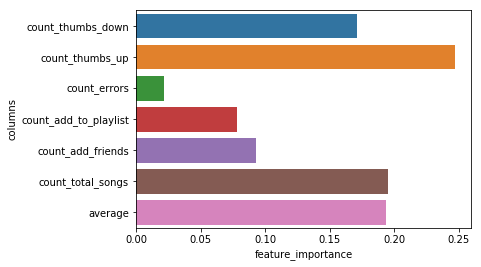

In [59]:
feature_importances = cvModel_gbt.bestModel.stages[2].featureImportances.values.tolist()
feature_importance_df = pd.DataFrame({'feature_importance': feature_importances, 'columns': input_col})
sns.barplot(x='feature_importance', y='columns', data=feature_importance_df)

From the bar above, count of thumbs up and average number of songs per session are more related to the number of churn of users.

# Conclusion
The number of churns in the male group is slightly higher than in the female group. However, the male group tends to not churn compared to the female group. The level of the free group has a higher churn than the level of the paid group. The positive feedback from users, the average number of songs per session, and total of played songs are more related to the churn rate of the users. Offer or incentives packages and adding a variety of songs can be implemented to assure the satisfaction of users with the services. The Gradient Boosting Tree model has the highest accuracy and F1 score which can be deployed in predicting the churn rate.

#  Discussion
There are more feature variables that can be added to the model such as the popularity of artists and songs and the length of time that users log in. The weight of feature importance helps Data Scientists in model optimization.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.